# Minimal Example

In [1]:
# %pip install matplotlib ipympl
import jax
jax.config.update("jax_enable_x64", True) # unfortunately we currently require double precision
import jax.numpy as jnp
import matplotlib.pyplot as plt
# %matplotlib widget

# jax.config.update('jax_platform_name', 'cpu')


In [2]:
## these are the main modules for background evolution and perturbation evolution
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, get_power, evolve_perturbations_batched

In [ ]:
@jax.jit
def compute_matter_power( Omegam=0.3099 ):

  ## Set the Cosmological Parameters
  # insert parameters into a dictionary
  param = {}
  # OmegaDE is inferred since flatness is assumed currently
  param['Omegam']  = Omegam            # Total matter density parameter
  param['Omegab']  = 0.0488911         # Baryon density parameter
  param['w_DE_0']  = -0.99             # Dark energy equation of state parameter today
  param['w_DE_a']  = 0.0               # Dark energy equation of state parameter time derivative
  param['cs2_DE']  = 1.0               # Dark energy sound speed squared
  param['Omegak']  = 0.0
  param['A_s']     = 2.1064e-09        # Scalar amplitude of the primordial power spectrum
  param['n_s']     = 0.96822           # Scalar spectral index
  param['H0']      = 67.742            # Hubble constant today in units of 100 km/s/Mpc
  param['Tcmb']    = 2.7255            # CMB temperature today in K
  param['YHe']     = 0.248             # Helium mass fraction
  param['Neff']    = 2.046             # Effective number of ultrarelativistic neutrinos
                                       # -1 if massive neutrino present
  param['Nmnu']    = 1                 # Number of massive neutrinos (must be 1 currently)
  param['mnu']     = 0.06              # Sum of neutrino masses in eV 
  param['k_p']     = 0.05              # Pivot scale in 1/Mpc

  # modes to sample
  nmodes = 512                         # number of modes to sample
  kmin   = 1e-4                        # minimum k in 1/Mpc
  kmax   = 10                          # maximum k in 1/Mpc
  aexp   = 1.0                         # scale factor at which to evaluate the power spectrum
  
  ## Compute Background+thermal evolution
  param = evolve_background(param=param, thermo_module='RECFAST')

  # compute perturbation evolution
  aexp_out = jnp.array([aexp])
  # jax.profiler.start_trace("/tmp/tensorboard")
  y, kmodes, param = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  # lmaxg = 31, lmaxgp = 31, lmaxr = 31, lmaxnu = 31, nqmax = 5, # from compare_class
                                  rtol=1e-3, atol=1e-3 , 
                                  )
  # jax.profiler.stop_trace()
  # turn perturbations into power spectra
  Pkm = get_power( k=kmodes, y=y[:,0,:], idx=4, param=param )

  return Pkm, kmodes

In [4]:
@jax.jit
def compute_matter_power_batched( Omegam=0.3099 ):

  ## Set the Cosmological Parameters
  # insert parameters into a dictionary
  param = {}
  # OmegaDE is inferred since flatness is assumed currently
  param['Omegam']  = Omegam            # Total matter density parameter
  param['Omegab']  = 0.0488911         # Baryon density parameter
  param['w_DE_0']  = -0.99             # Dark energy equation of state parameter today
  param['w_DE_a']  = 0.0               # Dark energy equation of state parameter time derivative
  param['cs2_DE']  = 1.0               # Dark energy sound speed squared
  param['Omegak']  = 0.0
  param['A_s']     = 2.1064e-09        # Scalar amplitude of the primordial power spectrum
  param['n_s']     = 0.96822           # Scalar spectral index
  param['H0']      = 67.742            # Hubble constant today in units of 100 km/s/Mpc
  param['Tcmb']    = 2.7255            # CMB temperature today in K
  param['YHe']     = 0.248             # Helium mass fraction
  param['Neff']    = 2.046             # Effective number of ultrarelativistic neutrinos
                                       # -1 if massive neutrino present
  param['Nmnu']    = 1                 # Number of massive neutrinos (must be 1 currently)
  param['mnu']     = 0.06              # Sum of neutrino masses in eV 
  param['k_p']     = 0.05              # Pivot scale in 1/Mpc

  # modes to sample
  nmodes = 512                         # number of modes to sample
  kmin   = 1e-4                        # minimum k in 1/Mpc
  kmax   = 10                          # maximum k in 1/Mpc
  aexp   = 1.0                         # scale factor at which to evaluate the power spectrum
  
  
  ## Compute Background+thermal evolution
  param = evolve_background(param=param, thermo_module='RECFAST')

  # compute perturbation evolution
  aexp_out = jnp.array([aexp])
  # jax.profiler.start_trace("/tmp/tensorboard")
  y, kmodes = evolve_perturbations_batched( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out,      
                                    # lmaxg = 31, lmaxgp = 31, lmaxr = 31, lmaxnu = 31, nqmax = 5, # from compare class
                                    # rtol=1e-5, atol=1e-5 , batch_size=32, max_steps=32768
                                    rtol=1e-3, atol=1e-3,
                                    )
  
  # jax.profiler.stop_trace()
  # turn perturbations into power spectra
  Pkm = get_power( k=kmodes, y=y[:,0,:], idx=4, param=param )

  return Pkm, kmodes

## Compute and plot the matter power spectrum batched

In [5]:
# might take ~ a minute to compile on first run, ~3s on rerun (RTX3090), 
# increase accuracy (rtol,atol) to reduce noise on derivatives
Omegam_fid = 0.3099

Pkm_batched, kmodes_batched = compute_matter_power_batched( Omegam_fid )



2024-09-20 20:22:30.825310: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


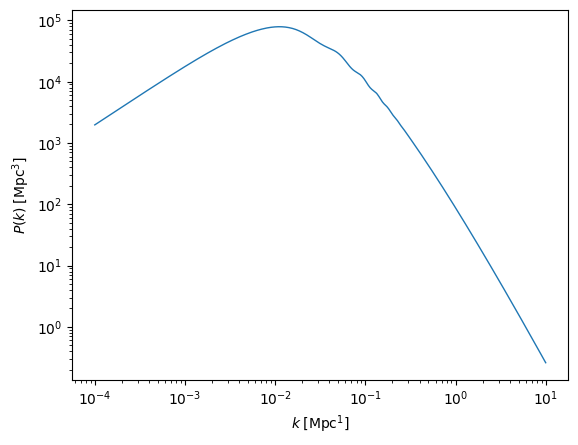

In [6]:
fig, ax = plt.subplots()

ax.plot(kmodes_batched, Pkm_batched, label='delta_m', lw=1)
ax.loglog()
ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
ax.set_ylabel(r'$P(k)\;[\text{Mpc}^{3}]$')
plt.show()

In [7]:

%timeit compute_matter_power_batched( Omegam_fid )

1.98 s ± 640 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Compute and plot the matter power spectrum

In [8]:
# might take ~ a minute to compile on first run, ~3s on rerun (RTX3090), 
# increase accuracy (rtol,atol) to reduce noise on derivatives
Omegam_fid = 0.3099
Pkm, kmodes = compute_matter_power( Omegam_fid )


In [9]:

%timeit compute_matter_power( Omegam_fid )

2.47 s ± 619 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


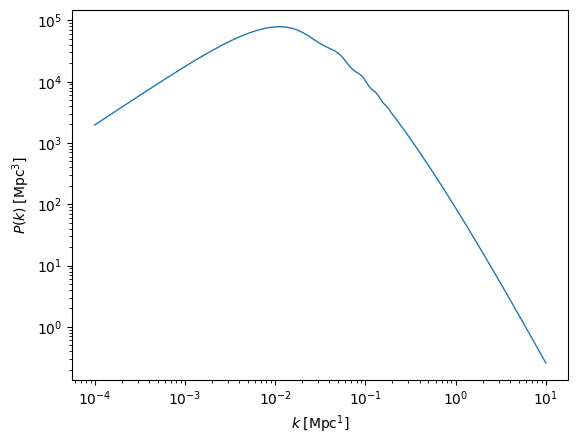

In [10]:
fig, ax = plt.subplots()

ax.plot(kmodes, Pkm, label='delta_m', lw=1)
ax.loglog()
ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
ax.set_ylabel(r'$P(k)\;[\text{Mpc}^{3}]$')
plt.show()

## Compute and plot the derivative of $P_m$ w.r.t. $\Omega_m$

In [11]:
# might take ~ 2 minutes to compile on first run, ~5s on rerun (RTX3090), 
# increase accuracy (rtol,atol) to reduce noise on derivatives
diff_matter_power = jax.jacfwd( compute_matter_power )
dPkm,_ = diff_matter_power( Omegam_fid )


In [22]:

%timeit diff_matter_power( Omegam_fid )

4.88 s ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# finite difference
Pkm_plus,_  = compute_matter_power( Omegam_fid + 1e-3 )
Pkm_minus,_ = compute_matter_power( Omegam_fid - 1e-3 )
dPkm_fd1     = (jnp.log(Pkm_plus)-jnp.log(Pkm_minus))/2e-3

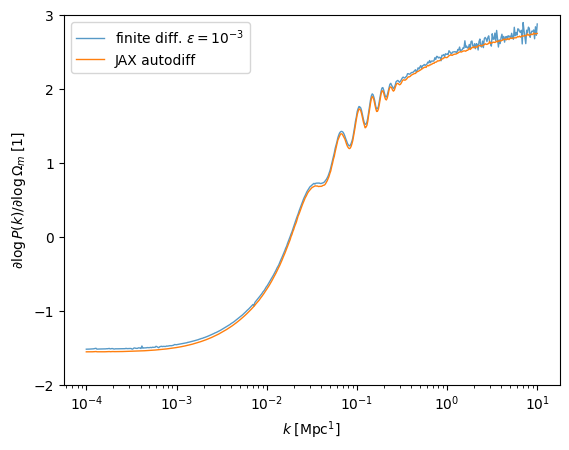

In [14]:
fig, ax = plt.subplots()
ax.semilogx(kmodes, Omegam_fid * dPkm_fd1, label='finite diff. $\\epsilon=10^{-3}$', alpha=0.75, lw=1)
ax.semilogx(kmodes, Omegam_fid * dPkm / Pkm, label='JAX autodiff', lw=1)
ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m\;[1]$')
ax.set_ylim(-2,3)
ax.legend()

### Compare to batched approach

In [15]:
diff_matter_power_batched = jax.jacfwd( compute_matter_power_batched )
dPkm,_ = diff_matter_power_batched( Omegam_fid )


In [23]:

%timeit diff_matter_power_batched( Omegam_fid )

3.96 s ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# finite difference
Pkm_plus,_  = compute_matter_power_batched( Omegam_fid + 1e-3 )
Pkm_minus,_ = compute_matter_power_batched( Omegam_fid - 1e-3 )
dPkm_fd1     = (jnp.log(Pkm_plus)-jnp.log(Pkm_minus))/2e-3

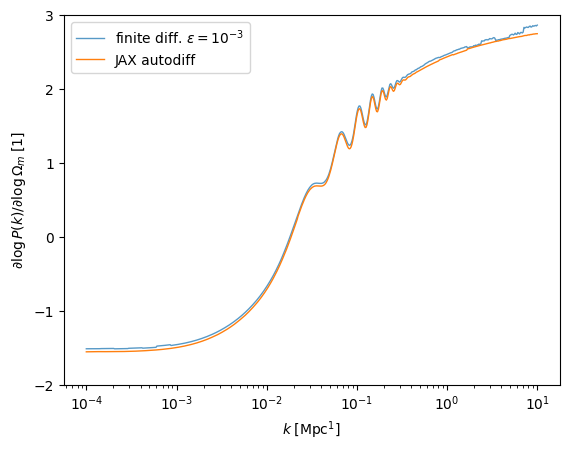

In [18]:
fig, ax = plt.subplots()
ax.semilogx(kmodes, Omegam_fid * dPkm_fd1, label='finite diff. $\\epsilon=10^{-3}$', alpha=0.75, lw=1)
ax.semilogx(kmodes, Omegam_fid * dPkm / Pkm, label='JAX autodiff', lw=1)
ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m\;[1]$')
ax.set_ylim(-2,3)
ax.legend()